# Dataset: Employee Churn

Your first client is Pear Inc, a multinational company worried about its poor talent retention. Pear has a peculiar hiring strategy. They offer free classes and hire the best students. The strategy is working, but many new hires leave the company after a few months. This is a huge waste of time and money.

In the past few months, they collected a dataset with information about their employees and recorded whether they churned or not. Due to the churning period being so short, they are confident that the history of each candidate is enough to predict the churn and the experience is Pear is not relevant.

Gabriele, the Head of Talent, is counting on you to put a plug in this problem. And Fabio, an ML Engineer and new colleague of yours, will be eyeing your work too!

**Challenge 1**: Pear Inc needs your help to figure out what makes an employee stick versus split. Craft a Jupyter notebook to answer their question. Keep it simple enough for Gabriele but detailed enough to dazzle Fabio.

## Library import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps
import math

import my_functions

from ydata_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [2]:
data_raw = pd.read_csv("../datasets/employee-churn/churn.csv")
data_raw.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

### Features

- enrollee_id: Unique ID for candidate 
- city: City code 
- city_development_index: Development index of the city (scaled)
- gender: Gender of candidate 
- relevant_experience: Relevant experience of candidate 
- enrolled_university: Type of University course enrolled if any 
- education_level: Education level of candidate 
- major_discipline: Education discipline of candidate 
- experience: Candidate total experience in years 
- company_size: Number of employees in current employer's company 
- company_type: Type of current employer 
- last_new_job: Difference in years between previous job and current job 
- training_hours: training hours completed 
- target: 0 – Not looking for job change, 1 – Looking for a job change

## Menage NaN values

Lets see the **percentage of missing values** in every columns.

In [4]:
data_raw.isna().sum()/len(data_raw)*100

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

### First approach: try to remove all the missing values

Let us evaluate the percentage of information that would be lost by removing all of the rows with at least one NaN values:

In [5]:
print(f"Percentage of discarded rows: {round((1 - (len(data_raw.dropna())/len(data_raw)))*100, 2)}%")

Percentage of discarded rows: 53.26%


This does not appear to be an advantageous choice because more than half of the dataset would be eliminated.

### Preprocessing data

It is necessary to convert some categorical data into numerical data. To do so I decided to use `sklearn.preprocessing.OrdinalEncoder`, in such a way the features are converted to ordinal integers. This is useful because you can add information to columns by introducing an order relationship; for example, regarding the level of education, the features coded as strings do not take into account the fact that a PhD requires more years of study than primary school while an ordinal encoder takes this into account. This data processing will be very useful especially during phase 2 of this project when predictive models will be trained.

Let's now define some labels for the categorical features that I will encode, this will be useful when I need to convert the integers back into string categories.

In [6]:
major_discipline_labels = ['No Major' 'Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
experience_labels = ['<1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
company_size_labels = ['None', '<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
last_new_job_labels = ['never','1','2','3','4','>4']

Let's start analyzing the missing values (NaN) and see if some of it can be reconstructed.

- **Major discipline**

    From the graph below you can see that the majority of people who do not have a _major_discipline_ are those who do not have a degree. For this reason, in the data reduction pipeline all NaN values with a High School and Primary qualification will be associated with the `No Major` value.

- **Enrolled university**

    For the same reason as before, all those who do not have a _major_discipline_ will be associated with `no_enrollment` as they have never attended a university.
    
- **Company type and size**

    From the graph below we can see that many unknown _company_type_ are related with values of _last_new_job_ equal to `never`, for this reason NaN entries corresponding to these value will be associated with `None` for both _company_type_ and _company_size_. To indicate that the candidate in question has never worked for any company. Furthermore, the remaining NaN values will be associated, respectively, with a value of `Unknown` and `-1`, to indicate that the candidate has not expressed this information.
  
- **Gender**

    Regarding gender, all NaN values are replaced by the value `Not given` to indicate that the candidate has not expressed any preference.

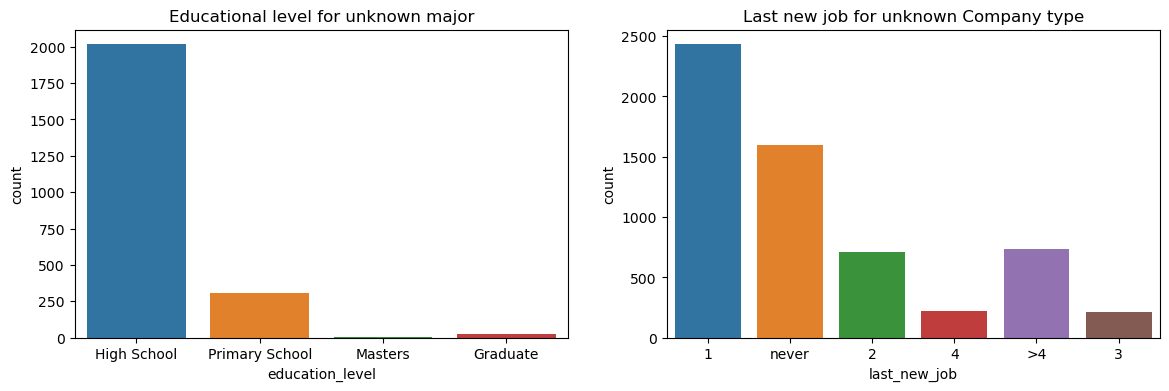

In [7]:
_, axs = plt.subplots(1,2, figsize=(14,4))

sns.countplot(data_raw[data_raw['major_discipline'].isna()], x='education_level', ax = axs[0]).set_title('Educational level for unknown major')
sns.countplot(data_raw[data_raw['company_type'].isna()], x='last_new_job', ax = axs[1]).set_title('Last new job for unknown Company type')

plt.show()

In [8]:
data = my_functions.data_preprocessing(data_raw)
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,target_label
0,8949,103.0,0.920,Male,True,no_enrollment,2.0,STEM,20.0,-1.0,Not given,1.0,36,1.0,Looking for a job change
1,29725,40.0,0.776,Male,False,no_enrollment,2.0,STEM,14.0,3.0,Pvt Ltd,5.0,47,0.0,Not looking for job change
2,11561,21.0,0.624,Not given,False,Full time course,2.0,STEM,4.0,0.0,None,0.0,83,0.0,Not looking for job change
3,33241,115.0,0.789,Not given,False,NaN,2.0,Business Degree,0.0,0.0,Pvt Ltd,0.0,52,1.0,Looking for a job change
4,666,162.0,0.767,Male,True,no_enrollment,3.0,STEM,20.0,3.0,Funded Startup,4.0,8,0.0,Not looking for job change


In [9]:
data.isna().sum()/len(data_raw)*100

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.000000
relevent_experience       0.000000
enrolled_university       1.701639
education_level           4.008769
major_discipline          2.547239
experience                3.204927
company_size              0.000000
company_type              0.000000
last_new_job              2.207955
training_hours            0.000000
target                    0.000000
target_label              0.000000
dtype: float64

In [10]:
print(f"Percentage of discarded rows: {round((1 - (len(data.dropna())/len(data)))*100, 2)}%")

Percentage of discarded rows: 9.73%


Although the percentage of data that would be discarded has drastically reduced, it may still be too high; a **future improvement** could be to be able to better engineer the data to find relationships that help complete the missing values.

In [11]:
data = data.dropna()

## Plotting ordinal variables distributions

Now that the problem of missing data has been solved, we can move on to analyzing the various features to understand which ones most influence the decision to look for another job or not.

Starting from the ordinal features (city, city_development_index, experience and training_hours) I firstly decided to plot the distribution of the features by counting the number of observations that fall within discrete bins. I also highlighted how within the single bin the two groups are divided, those who will keep the job and those who will look for another one. 

Then I performed a KDE (kernel density estimation) useful for smoothing the distribution and obtaining a continuous curve. The usefulness of this procedure is that the curve obtained is normalized and can be considered a probability density distribution. Furthermore, the various features were always divided into the two groups of those who leave and those who remain into Pear Inc, and the normalization was performed individually on the two groups: in this way I obtained two probability distributions which can be compared.

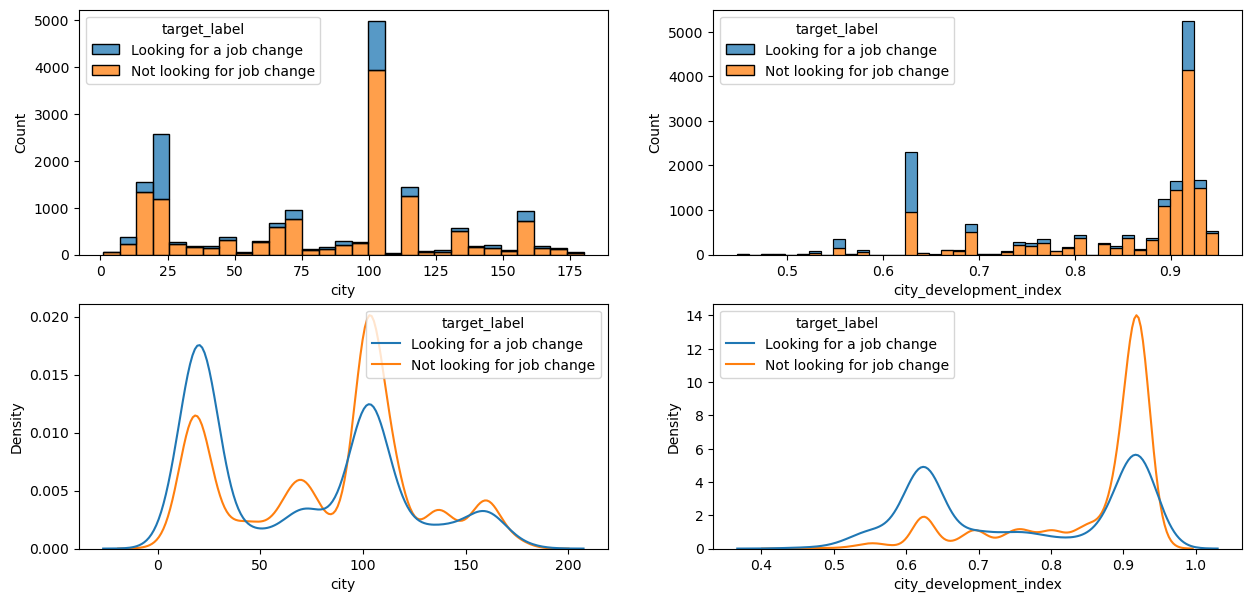

In [31]:
_, axs = plt.subplots(2,2, figsize=(15,7))

sns.histplot(data=data, x='city', hue='target_label', multiple='stack', ax = axs[0][0])
sns.histplot(data=data, x='city_development_index', hue='target_label', multiple='stack', ax = axs[0][1])

sns.kdeplot(data=data, x='city', hue='target_label',common_norm=False, ax = axs[1][0])
sns.kdeplot(data=data, x='city_development_index', hue='target_label',common_norm=False, ax = axs[1][1])

plt.show()

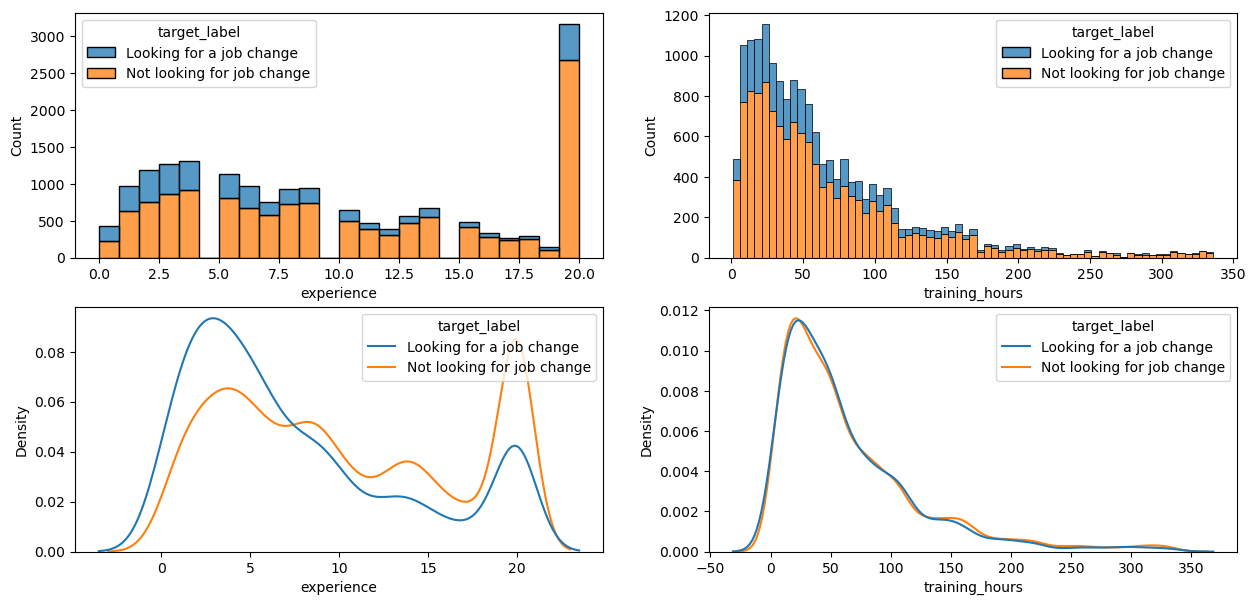

In [32]:
_, axs = plt.subplots(2,2, figsize=(15,7))

sns.histplot(data=data, x='experience', hue='target_label',multiple='stack', ax = axs[0][0])
sns.histplot(data=data, x='training_hours', hue='target_label',multiple='stack', ax = axs[0][1])

sns.kdeplot(data=data, x='experience', hue='target_label',common_norm=False, ax = axs[1][0])
sns.kdeplot(data=data, x='training_hours', hue='target_label',common_norm=False, ax = axs[1][1])

plt.show()

**Discuss the obtained results**

## Estimate categorical variables proportions

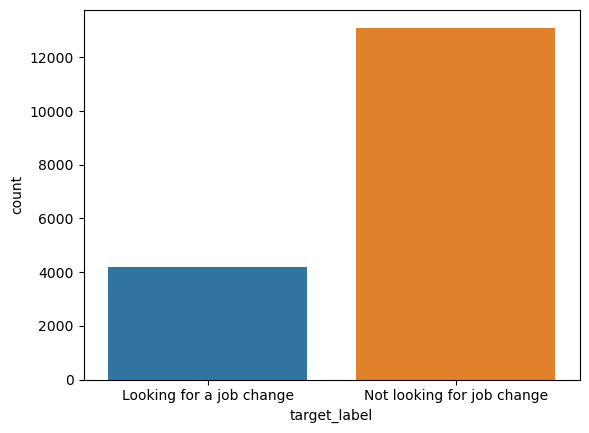

In [14]:
sns.countplot(data, x='target_label')
plt.show()

### Gender

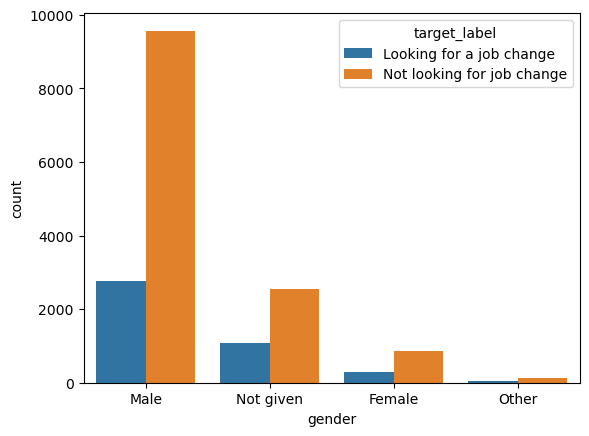

In [15]:
sns.countplot(data, x='gender', hue='target_label')
plt.show()

In [16]:
gender_dict = my_functions.print_percentage_and_ztest(data, 'gender')

Percentage of Not given quitting Pear Inc: 29.53%; z_score = 7.01
Percentage of Female quitting Pear Inc: 25.75%; z_score = 1.2
Percentage of Other quitting Pear Inc: 25.0%; z_score = 0.23
Percentage of Male quitting Pear Inc: 22.5%; z_score = -4.57


### Enrolled university

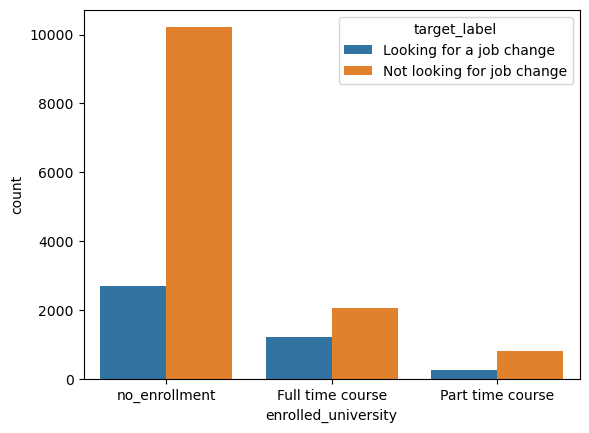

In [17]:
sns.countplot(data, x='enrolled_university', hue='target_label')
plt.show()

In [18]:
enrolled_uni_dict = my_functions.print_percentage_and_ztest(data, 'enrolled_university')

Percentage of Full time course quitting Pear Inc: 37.26%; z_score = 15.48
Percentage of Part time course quitting Pear Inc: 23.91%; z_score = -0.24
Percentage of no_enrollment quitting Pear Inc: 20.91%; z_score = -9.22


### Education level

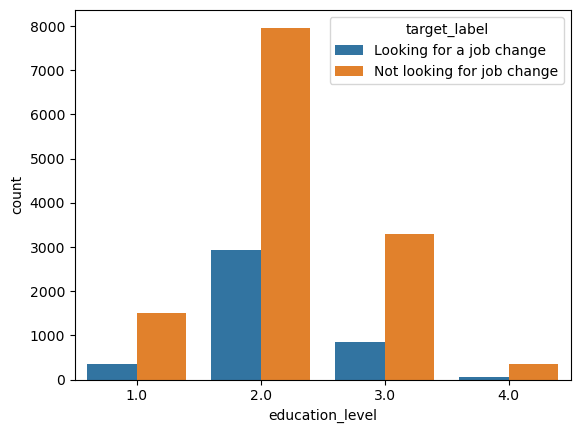

In [19]:
sns.countplot(data, x='education_level', hue='target_label')
plt.show()

In [20]:
education_dict = my_functions.print_percentage_and_ztest(data, 'education_level', major_discipline_labels)

Percentage of Graduate quitting Pear Inc: 26.9%; z_score = 6.33
Percentage of High School quitting Pear Inc: 18.94%; z_score = -5.78
Percentage of Masters quitting Pear Inc: 20.51%; z_score = -5.91
Percentage of Phd quitting Pear Inc: 13.64%; z_score = -6.13


### Major discipline

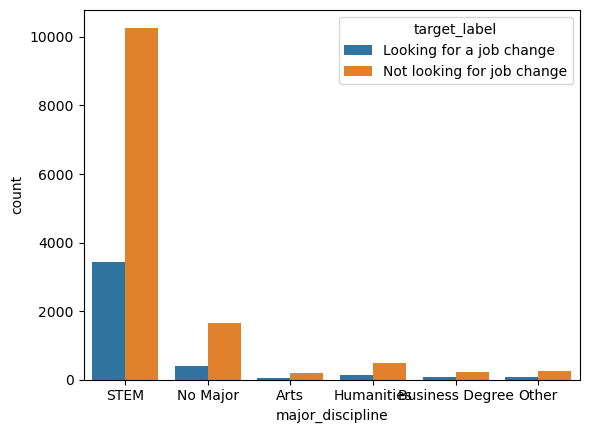

In [21]:
sns.countplot(data, x='major_discipline', hue='target_label')
plt.show()

In [22]:
major_dict = my_functions.print_percentage_and_ztest(data, 'major_discipline')

Percentage of STEM quitting Pear Inc: 25.12%; z_score = 2.44
Percentage of Business Degree quitting Pear Inc: 25.73%; z_score = 0.61
Percentage of Other quitting Pear Inc: 24.86%; z_score = 0.28
Percentage of Arts quitting Pear Inc: 21.1%; z_score = -1.18
Percentage of Humanities quitting Pear Inc: 20.06%; z_score = -2.59
Percentage of No Major quitting Pear Inc: 19.46%; z_score = -5.45


### Relevant experience

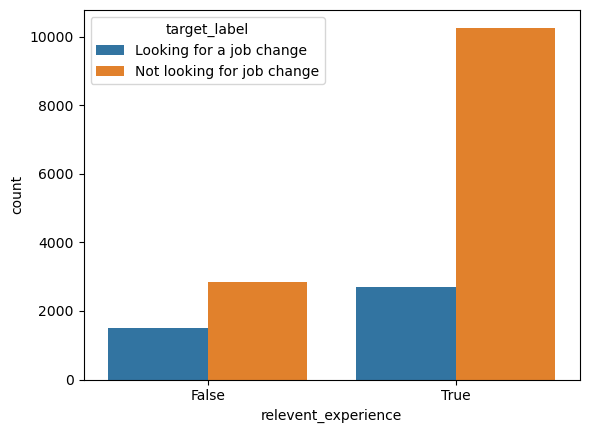

In [23]:
sns.countplot(data, x='relevent_experience', hue='target_label', )
plt.show()

In [24]:
relevent_exp_dict = my_functions.print_percentage_and_ztest(data, 'relevent_experience', ['Hasn\'t relevant experience', 'Has relevant experience'])

Percentage of Hasn't relevant experience quitting Pear Inc: 34.51%; z_score = 14.27
Percentage of Has relevant experience quitting Pear Inc: 20.76%; z_score = -9.69


### Company type

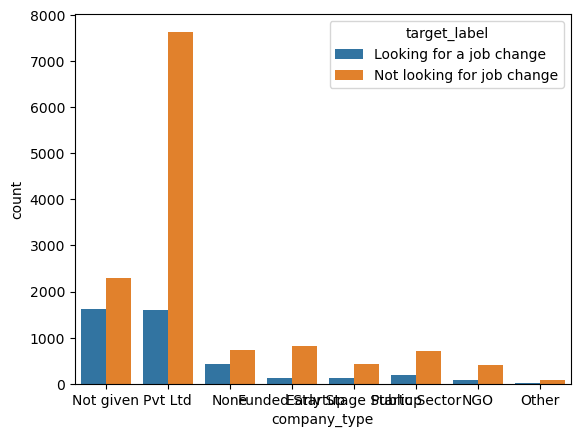

In [25]:
sns.countplot(data, x='company_type', hue='target_label')
plt.show()

In [26]:
company_type_dict = my_functions.print_percentage_and_ztest(data, 'company_type')

Percentage of Not given quitting Pear Inc: 41.35%; z_score = 21.81
Percentage of None quitting Pear Inc: 36.91%; z_score = 8.95
Percentage of Other quitting Pear Inc: 22.43%; z_score = -0.44
Percentage of Early Stage Startup quitting Pear Inc: 21.5%; z_score = -1.53
Percentage of Public Sector quitting Pear Inc: 20.95%; z_score = -2.39
Percentage of NGO quitting Pear Inc: 17.25%; z_score = -4.07
Percentage of Funded Startup quitting Pear Inc: 13.6%; z_score = -9.57
Percentage of Pvt Ltd quitting Pear Inc: 17.29%; z_score = -17.59


### Company size

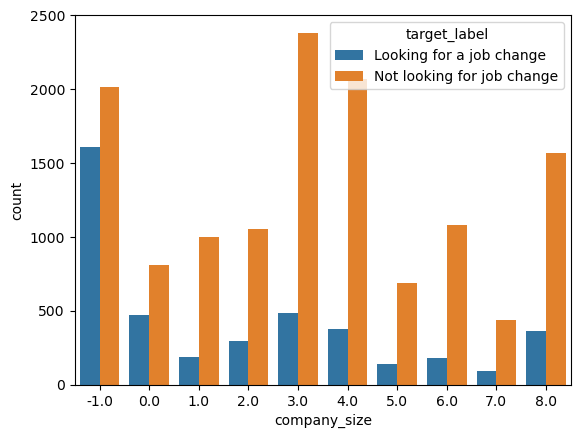

In [27]:
sns.countplot(data, x='company_size', hue='target_label')
plt.show()

In [28]:
company_size_dict = my_functions.print_percentage_and_ztest(data, 'company_size', company_size_labels)

Percentage of None quitting Pear Inc: 36.9%; z_score = 9.41
Percentage of 10/49 quitting Pear Inc: 21.93%; z_score = -2.02
Percentage of 5000-9999 quitting Pear Inc: 16.92%; z_score = -4.46
Percentage of 500-999 quitting Pear Inc: 16.75%; z_score = -5.76
Percentage of 10000+ quitting Pear Inc: 18.69%; z_score = -6.22
Percentage of <10 quitting Pear Inc: 15.73%; z_score = -8.04
Percentage of 1000-4999 quitting Pear Inc: 14.14%; z_score = -10.26
Percentage of 50-99 quitting Pear Inc: 16.91%; z_score = -10.43
Percentage of 100-500 quitting Pear Inc: 15.3%; z_score = -12.25
